In [2]:
import os
import numpy as np
import random
import torch
import glob
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
from torchvision import datasets
from scipy.io import loadmat
import pathlib
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage.measure import compare_psnr

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def activation_layer(activation:str):

    if activation == 'leaky':
        return nn.LeakyReLU(negative_slope=0.1)


In [3]:
def normalization_layer(normalization: str,
                      num_channels: int, dim:int):
    if dim == 2:
        if normalization == 'BN':
            return nn.BatchNorm2d(num_channels)
    elif dim == 3:
        if normalization == 'BN':
            return nn.BatchNorm3d(num_channels)


In [4]:
def pooling_layer(pooling:str, dim:int):
    if dim == 2:
        if pooling == "max":
            return nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        elif pooling == 'avg':
            return nn.AvgPool2d(kernel_size=2,stride=2,padding=0)

    if dim == 3:
        if pooling == "max":
            return nn.MaxPool3d(kernel_size=2,stride=2,padding=0)
        elif pooling == 'avg':
            return nn.AvgPool3d(kernel_size=2,stride=2,padding=0)


In [5]:
def conv_layer(in_chs, out_chs, kernel_size, stride, padding, dim):
    if dim == 2:
        return nn.Conv2d(in_chs, out_chs, kernel_size, stride, padding)
    elif dim == 3:
        return nn.Conv3d(in_chs, out_chs, kernel_size, stride, padding)

In [6]:
def up_sample_layer(up_sample,in_chs = None, out_chs = None, kernel_size = 2, stride = 2, dim = 3):
    if up_sample == 'transposed':
        if dim == 2:
            return nn.ConvTranspose2d(in_chs, out_chs, kernel_size,stride)
        elif dim == 3:
            return nn.ConvTranspose3d(in_chs, out_chs, kernel_size,stride)
    else:
        return nn.Upsample(scale_factor=2, mode=up_sample) # mode can be 'nearest', 'bilinear' ,...

In [7]:
def Cat(tensor1, tensor2):
    
    x = torch.cat((tensor1, tensor2), 1)

    return x

In [8]:
def Add (tensor1, tensor2):
    
    x = torch.add(tensor1, tensor2)
    
    return x

In [9]:
class DownBlock(nn.Module):
    """
    represent a block from the left part of  U shape.
    it contains two convolution layers, 
    each followed by a batch normalization (BN) and a leaky rectified,
    and a downsampling layer followed by a BN and leakyRElu
      
    
    """

    def __init__(self,
                 in_ch,
                 out_ch,
                 stride_pooling:bool,
                 pooling: str = "max",     
                 kernel_size: int = 3,
                 stride:int = 1,
                 padding: int = 1,
                 activation: str = 'leaky',
                 normalization: str = 'BN',
                 dim: int = 2
                 ):
        super().__init__()

        self.in_ch = in_ch
        self.out_ch = out_ch
        self.pooling = pooling
        self.stride_pooling = stride_pooling
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.activation = activation
        self.normalization = normalization
        self.dim = dim
        
        self.activation_layer = activation_layer(self.activation)
        self.normalization_layer = normalization_layer(normalization=self.normalization, num_channels=self.out_ch,
                                           dim=self.dim)       
        self.pooling_layer = pooling_layer(pooling = self.pooling, dim=self.dim)
        self.stride_layer = conv_layer(self.out_ch, self.out_ch, kernel_size = self.kernel_size, stride = 2, padding = self.padding, 
                                          dim = self.dim)      
        self.conv_layer1 = conv_layer(self.in_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
        self.conv_layer2 = conv_layer(self.out_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)


    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.normalization_layer(x)
        x = self.activation_layer(x)
        x = self.conv_layer2(x)
        x = self.normalization_layer(x)
        x = self.activation_layer(x)
        connect_layer = x
        if self.stride_pooling:
            x = self.stride_layer(x)            
        else:
            x =  self.pooling_layer(x)
        x = self.normalization_layer(x)
        x = self.activation_layer(x)
                                                       
        return x,connect_layer


In [10]:
class Latent(nn.Module):
    """
    Latent, also called bottleneck, represents the bottom middle part of the UNet.
    In this work, it contains a conv+BN+LeakyRelu + conv+BN+LeakyRelu.
    """
    def __init__(self,
                 in_ch,
                 out_ch,
                 kernel_size = 3,
                 stride = 1,
                 padding = 1,
                 activation: str = 'leaky',
                 normalization: str = "BN",
                 dim: int = 2

                 ):
        super().__init__()

        self.in_ch =in_ch
        self.out_ch = out_ch
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.activation = activation
        self.normalization = normalization
        self.dim = dim
        
        self.activation_layer = activation_layer(self.activation)
        self.norm_layer = normalization_layer(normalization=self.normalization, num_channels=self.out_ch,
                                           dim=self.dim) 
        self.conv_layer1 = conv_layer(self.in_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)          
        self.conv_layer2 = conv_layer(self.out_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
    def forward(self,x):
        x = self.conv_layer1(x)
        x = self.norm_layer(x)
        x = self.activation_layer(x)
        x = self.conv_layer2(x)
        x = self.norm_layer(x)
        x = self.activation_layer(x)
        
        return x
        


In [11]:
class UpBlock(nn.Module):
    """
    it corresponds to "red arrow+blue arrow+ blue arrow", i.e.
    [decon_layer (half the number of channels)+ Upsampling (double image size)]+
    [conv+bn+leaky]+[con+bn+leaky]
    """

    def __init__(self,
                 in_ch,
                 out_ch,
                 concatenate:bool = False,
                 add : bool = False,
                 Crop:bool = False,
                 kernel_size = 3,
                 stride = 1,
                 padding = 1,
                 activation: str = 'leaky',
                 normalization: str = "BN",
                 dim: int = 2,
                 up_sample: str = 'nearest'
                 ):
        super().__init__()

        self.in_ch =in_ch
        self.out_ch = out_ch
        self.concatenate = concatenate
        self.add = add
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.activation = activation
        self.normalization = normalization
        self.dim = dim
        self.up_sample = up_sample
        self.Crop = Crop
        

    
        self.activation_layer = activation_layer(self.activation)
     
        self.up_sample_layer = up_sample_layer(up_sample = self.up_sample)
        
        self.conv_layer1 = conv_layer(self.in_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
        if self.add:
            self.conv_layer2 = conv_layer(self.out_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
        elif self.concatenate:
            self.conv_layer2 = conv_layer(self.in_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
            self.conv_layer3 = conv_layer(self.out_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
        self.norm_layer = normalization_layer(normalization=self.normalization, num_channels=self.out_ch,
                                           dim=self.dim)        
            
    def forward(self, x, connect_layer):

        #deconv + upsample
        x = self.conv_layer1(x) #128 -> 64
        x = self.up_sample_layer(x) # 32*32 -> 64*64
        
        #merge
        if self.concatenate:
            x = Cat(connect_layer,x) #64 -> 128
            x = self.conv_layer2(x) #128->64
            x = self.norm_layer(x) 
            x = self.activation_layer(x)
            x = self.conv_layer3(x) #64 -> 64
            x = self.norm_layer(x)
            x = self.activation_layer(x)
            
        elif self.add:
            x = Add(connect_layer,x)
        
            #conv+bn+lrelu
            x = self.conv_layer2(x)
            x = self.norm_layer(x)
            x = self.activation_layer(x)
            #conv+bn+lrelu
            x = self.conv_layer2(x)
            x = self.norm_layer(x)
            x = self.activation_layer(x)
        
        

        return x


In [12]:
class last_block(nn.Module):
    """
    it's the last block of layers after the UpBlock to make channel 16 into channel 1.
    it contains conv+bn+leakyRelu
    """
    def __init__(self,
                 in_ch,
                 out_ch,
                 kernel_size = 3,
                 stride = 1,
                 padding = 1,
                 activation: str = 'leaky',
                 normalization: str = "BN",
                 dim: int = 2

                 ):
        super().__init__()
        
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.activation = activation
        self.normalization = normalization
        self.dim = dim
        
        self.conv_layer_final = conv_layer(self.in_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
        self.norm_layer_final = normalization_layer(normalization=self.normalization, num_channels=self.out_ch,
                                           dim=self.dim) 
        
        
        
    def forward(self,x):

        x = self.conv_layer_final(x)
        x = self.norm_layer_final(x)
        #x = act_layer(x)
        #x = nn.Sigmoid()(x)
        #x = nn.Linear(256,256)(x)
        return x
    
    

In [13]:
class UNet(nn.Module):
    """
    it combines DownBlock + middle bottom of U shape + UpBlock + the final conv_layer.
    we want to follow the UNet from the paper, so  here depth is 3, which means
    the UNet will first run DownBlock for three times,
    then reach the bottom, and will run "conv+bn+leaky" +"conv+bn+leaky",
    then will run UpBlock for three times,
    then we add the last layer to make channels from 16 -> 1

    """
    def __init__(self,
                 stride_pooling:bool,
                 chs = [1,16,32,64,128],
                 concatenate:bool = False,
                 add:bool = False,
                 Crop:bool=False,
                 pooling = "max",
                 
                 kernel_size = 3,
                 stride = 1,
                 padding = 1,
                 activation: str = 'leaky',
                 normalization: str = "BN",
                 dim: int = 3,
                 up_sample: str = 'nearest'
                 ):
        super().__init__()

        self.chs = chs
        self.depth = len(chs)-2
        self.pooling = pooling
        self.stride_pooling = stride_pooling
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.activation = activation
        self.normalization = normalization
        self.dim = dim
        self.concatenate = concatenate
        self.add = add
        self.up_sample = up_sample
        self.Crop = Crop
        
        
        self.encoder = nn.ModuleList([])
        self.decoder = nn.ModuleList([])
        self.latent = Latent(in_ch = self.chs[-2],
                             out_ch = self.chs[-1],
                             kernel_size = self.kernel_size,
                             stride = self.stride,
                             padding = self.padding,
                             activation = self.activation,
                             normalization = self.normalization,
                             dim = self.dim)
        self.last_block = last_block(in_ch = self.chs[1],
                             out_ch = self.chs[0],
                             kernel_size = self.kernel_size,
                             stride = self.stride,
                             padding = self.padding,
                             activation = self.activation,
                             normalization = self.normalization,
                             dim = self.dim)
        
        for i in range(self.depth):
            encoder_layer = DownBlock(
                 in_ch=self.chs[i],
                 out_ch=self.chs[i+1],
                 #concatenate = True,
                 stride_pooling = self.stride_pooling,
                 pooling = self.pooling,
                 kernel_size = self.kernel_size,
                 stride = self.stride,
                 padding = self.padding,
                 activation = self.activation,
                 normalization = self.normalization,
                 dim= self.dim)
            
            self.encoder.append(encoder_layer) #encoder is the modulelist, and it appends each downblocks
            
            decoder_layer = UpBlock(
                 in_ch = self.chs[-1-i],
                 out_ch = self.chs[-2-i],
                 concatenate= self.concatenate,
                 add = self.add,
                 Crop=self.Crop,
                 kernel_size = self.kernel_size,
                 stride = self.stride,
                 padding = self.padding,
                 activation= self.activation,
                 normalization = self.normalization,
                 dim = self.dim,
                 up_sample= self.up_sample) 
            
            self.decoder.append(decoder_layer)
            
        self.set_weights()
        

    @staticmethod        
    def weight_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            #nn.init.xavier_normal(m.weight)
            nn.init.constant(m.bias, 0)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('Sigmoid') != -1:
            nn.init.xavier_normal(m.weight)
        #elif classname.find('Leaky') != -1:
            #nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        elif classname.find('Linear') != -1:
            nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
   
    def set_weights(self):
        for i,m in enumerate(self.modules()):
            self.weight_init(m)
            
        
    def forward(self,x):
        connect_list = [] #it contains the layer from encoder path which need to skip to connect
        
        #encoder path
        for i in range(self.depth):
            block = self.encoder[i]
            x,connect_layer = block(x)
            connect_list.append(connect_layer)
            
        #bottom block: the middle and bottom part of UNet
        
        x = self.latent(x)
        
        #decoder path
        for i in range(self.depth):
            layer_to_connect = connect_list[-1-i]
            block = self.decoder[i]
            x = block(x,layer_to_connect)
            
        #last layer : 16 to 1
        x = self.last_block(x)
        
        
            
        return x
                
            

# upload image and noise

In [14]:
def upload_image_not_normalize(file_name):
    """
    This function uploads the data.
    input:
        file_name is a str, e.g. 'xcat.mat'
    returns:
        Pmean: the mean of temporal frames. Shape(1,1,256,256,400)
        blurry_P : each temporal frames has been added Gaussian noise with sigma = 5. Shape(1,1,256,256,400,14)
        Pgt :ground-truth / original image. Shape(1,1,256,256,400,14)
    """
    P = loadmat(file_name)
    p = P['data']

    P1= torch.from_numpy(p)
    P14 = P1#P14 has 14 temporal frames
    Pgt = P14.unsqueeze(0)
    Pgt = Pgt.unsqueeze(0)# shape (1,1,256,256,400,14)
    
    #mean temporal frame
    P1 = torch.mean(P1,dim=3) 
    P = P1.unsqueeze(0)
    Pmean = P.unsqueeze(0) #shape will be (1,1,256,256,400)

    #each temporal frame+gaussian noise
    g_noise = torch.normal(0,5,(256,256,400,14)) #create a gaussian with mean 0, sigma 5
    noisyP=P14
    noisyP=noisyP + g_noise   
    blurry_P = noisyP.unsqueeze(0)
    blurry_P = blurry_P.unsqueeze(0)# shape (1,1,256,256,400,14)
    
    
    return Pmean,blurry_P,Pgt
    

In [ ]:
def upload_image(file_name):
    """
    This function uploads and normalize the data.
    input:
        file_name is a str, e.g. 'xcat.mat'
    returns:
        Pmean: the mean of temporal frames. Shape(1,1,256,256,400)
        blurry_P : each temporal frames has been added Gaussian noise with sigma = 5. Shape(1,1,256,256,400,14)
        Pgt :ground-truth / original image. Shape(1,1,256,256,400,14)
    """
    P = loadmat(file_name)
    p = P['data']

    P1= torch.from_numpy(p)
    P14 = P1#P14 has 14 temporal frames
    Pgt = (P14-P14.min())/(P14.max()-P14.min())
    Pgt = Pgt.unsqueeze(0)
    Pgt = Pgt.unsqueeze(0)# shape (1,1,256,256,400,14)
    
    #mean temporal frame
    P1 = torch.mean(P1,dim=3) 
    P = (P1-P1.min())/(P1.max()-P1.min()) #scale P1 to (0,1)
    P = P.unsqueeze(0)
    Pmean = P.unsqueeze(0) #shape will be (1,1,256,256,400)

    #each temporal frame+gaussian noise
    g_noise = torch.normal(0,5,(256,256,400,14)) #create a gaussian with mean 0, sigma 5
    noisyP=P14
    noisyP=noisyP + g_noise   
    blurry_P = (noisyP-noisyP.min())/(noisyP.max()-noisyP.min()) #normalize the blurry image
    blurry_P = blurry_P.unsqueeze(0)
    blurry_P = blurry_P.unsqueeze(0)# shape (1,1,256,256,400,14)
    
    
    return Pmean,blurry_P,Pgt
    

In [3]:
Pmean,blurry_P,Pgt = upload_image_not_normalize('xcat.mat')


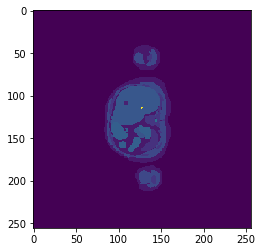

In [15]:
plt.imshow(Pmean[0,0,:,:,120])

# save the output images


In [15]:
def save_output_img(output_img,epoch,i,folder,train_loss,psnr,cc): # i is for telling which time (from 1 to 14); 
                                                                   #folder has three types because there are three kids of input_image
    fig = plt.figure()
    ax = fig.add_subplot(111)   
    plot = plt.imshow(output_img[0,0,:,:,120])
    plt.clim(0,1)#have same color range
    plt.title('Dynamic time:{},Epoch: {}, Training Loss: {:.5f}, PSNR: {:.5f},CC:{:.5f}'.format(i+1,epoch+1, train_loss,psnr,cc))

    plt.savefig(folder+'output_image{}-{}.png'.format(i+1,epoch+1)) #e.g. output_image1-1000 means the 1000th image at time 1
    plt.close(fig)#not display the image

# train function

In [16]:
def optim(optimizer:str = 'Adam'):
    if optimizer == 'Adam':
        return Adam(model.parameters(), lr=1e-3)
    elif optimizer == 'SGD':
        return torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [17]:
def loss(criterion:str = 'MSE'):
    if criterion == 'MSE':
        return nn.MSELoss()

In [18]:
def train_setup(model,criterion_name,optimizer_name,input_image,label_image,epoch,i,folder):
    optimizer = optim(optimizer_name)
    criterion = loss(criterion_name)


    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
        
    def train(epoch):
    #strat TRAIN mode
        model.train()
        train_loss = 0.0
        
        x_train, label= Variable(input_image), Variable(label_image)
    

        if torch.cuda.is_available():
        
            x_train = x_train.cuda()           
            label = label.cuda()
    
        optimizer.zero_grad()
        output = model(x_train)
        output_img = output.detach().numpy()
        
        loss = criterion(output,label)
    #compute gradient
        loss.backward()
    #update parameters
        torch.nn.utils.clip_grad_norm_(model.parameters(),1)
        optimizer.step()    
         
    
        train_loss = loss.item()
        
        #correlation coeeficient
        cm = np.corrcoef(output_img[0,0,:,:,120].flat,label_image[0,0,:,:,120].numpy().flat)
        cc = cm[0,1]
        
        #psnr
        psnr = compare_psnr(label_image.numpy(), output_img,1)        
        
        loss_list.append(train_loss)
        cc_list.append(cc)
        psnr_list.append(psnr)
        

        
        print('Epoch: {} \tTraining Loss: {:.6f} \tPSNR: {:.6f} \tCC:{:6f}'.format(epoch, train_loss,psnr,cc))
        
        
        if (epoch+1) %100 == 0:  #this only display the output of tevery 100 iteration
            #fig.add_subplot(3,4,(epoch+1)/200)
            #plt.imshow(output_img[0,0,:,:])
            #plt.clim(0,1)
            
            save_output_img(output_img,epoch,i,folder,train_loss,psnr,cc)
            
    
    return train(epoch)
    
 

#  training process

In [19]:
unet = UNet(stride_pooling = True,
                 chs = [1,16,32,64,128],
                 concatenate= False,
                 add = True,
                 Crop=False,
                 pooling = "max",
                 
                 kernel_size = 3,
                 stride = 1,
                 padding = 1,
                 activation= 'leaky',
                 normalization = "BN",
                 dim= 3,
                 up_sample= 'nearest')

C:\Users\h\anaconda3\lib\site-packages\ipykernel_launcher.py:105: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


In [22]:
from torchsummary import summary

In [ ]:
summary(unet, (1,256,256,400), batch_size=1)

In [23]:
file_name = 'xcat.mat'
Pmean,blurry_P,Pgt = upload_image_not_normalize(file_name)
uniform_noise = torch.randn(1,1,256,256,400)

In [24]:
model = unet
#model = unet
criterion_name = 'MSE'
optimizer_name = 'Adam'
#input_image = p_noise
#input_image = P1
input_image1 = uniform_noise
input_image2 = Pmean
input_image3 = blurry_P
#label_image = P1

In [1]:
Pmean.shape

NameError: name 'Pmean' is not defined

# create a folder for all the output images

In [23]:
file_name = 'xcat.mat'
folder1 = file_name[0:3]+'_mean_frame/'
folder2 = file_name[0:3]+'_noise/'
folder3 = file_name[0:3]+'_blurryImage/'

In [24]:
os.makedirs(folder1)
os.makedirs(folder2)
os.makedirs(folder3)

# iterate the training

In [ ]:
num_epochs = 200
train_loss = 0
loss_list = []
cc_list = []
psnr_list = []

for i in range(14): #time = 14
    label_image = Pgt[0,0,:,:,:,i]
    for epoch in range(num_epochs):
        train_setup(model,criterion_name,optimizer_name,input_image1,label_image,epoch,i,folder1)


In [ ]:
for i in range(14): #time = 14
    label_image = Pgt[0,0,:,:,:,i]
    for epoch in range(num_epochs):
        train_setup(model,criterion_name,optimizer_name,input_image2,label_image,epoch,i,folder2)

In [ ]:
for i in range(14): #time = 14
    label_image = Pgt[0,0,:,:,:,i]
    for epoch in range(num_epochs):
        train_setup(model,criterion_name,optimizer_name,input_image3,label_image,epoch,i,folder3)

# plot training loss

In [ ]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)  
plt.plot(loss_list,label='Training loss')
plt.title('Training Loss')
plt.savefig(folder1+'loss.png')
plt.close(fig1)#not display the image

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)  
plt.plot(psnr_list,label='PSNR')
plt.title('PSNR')
plt.savefig(folder2+'PSNR.png')
plt.close(fig2)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)  
plt.plot(cc_list,label='cc')
plt.title('Pearson correlation coefficient')
plt.savefig(folder3+'cc.png')
plt.close(fig3)